In [1]:
from model_explorer.result_handling.collect_results import collect_results

In [7]:
# results8x8 = collect_results('../results/different_ga_settings')
# results8x8alt = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-17_slurmid_0.pkl')
# results16x16 = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-13_slurmid_1.pkl')
# results1x16 = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-23_slurmid_2.pkl')
# results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-41-29_slurmid_0.csv
# results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-49-22_slurmid_1.csv
# results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-57-39_slurmid_2.csv
results = collect_results('../results/expl_quantization_problem_resnet50_imagenet_2023-03-12_19-50.pkl')

# df8x8 = results8x8.to_dataframe()
# df8x8alt = results8x8alt.to_dataframe()
# df16x16 = results16x16.to_dataframe()
# df1x16 = results1x16.to_dataframe()
dfin = results.to_dataframe()

# df8x8 = df8x8[df8x8['accuracy'] > 0.7]
# df8x8['F_0'] = -df8x8['F_0'] * 1_000_000
# df8x8 = df8x8[df8x8['accuracy'] > 0.7]
# df8x8['F_0'] = -df8x8['F_0'] * 1_000_000

In [8]:
def prepare(df):
    df['accuracy'] = -df['accuracy'] + results.accuracy_limit
    df = df[df['accuracy'] > 0.7]
    # df['F_0'] =  -df['F_0'] * 1_000_000
    return df

df_prep = prepare(dfin)
# df8x8 = prepare(df8x8)
# df1x16 = prepare(df1x16)
# df16x16 = prepare(df16x16)
# df8x8alt = prepare(df8x8alt)
print(df_prep.shape)
df_prep.head()

(382, 10)


,generation,individual,accuracy,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,parameters
15,1,0,0.752930,10,1.0,5,0.9,2,3044.0,"[10, 11, 9, 8, 6, 9, 6, 7, 11, 11, 11, 12, 11,..."
16,1,1,0.757568,10,1.0,5,0.9,2,3123.5,"[12, 11, 13, 13, 7, 7, 11, 7, 8, 9, 13, 11, 14..."
17,1,2,0.741943,10,1.0,5,0.9,2,3185.5,"[12, 6, 13, 13, 7, 9, 14, 12, 11, 12, 12, 9, 1..."
18,1,3,0.733643,10,1.0,5,0.9,2,3164.0,"[4, 13, 11, 14, 7, 10, 14, 12, 11, 13, 12, 13,..."
23,2,0,0.765137,10,1.0,5,0.9,2,2894.0,"[11, 11, 12, 12, 9, 7, 12, 7, 9, 9, 13, 13, 13..."


<AxesSubplot: xlabel='accuracy', ylabel='F_0'>

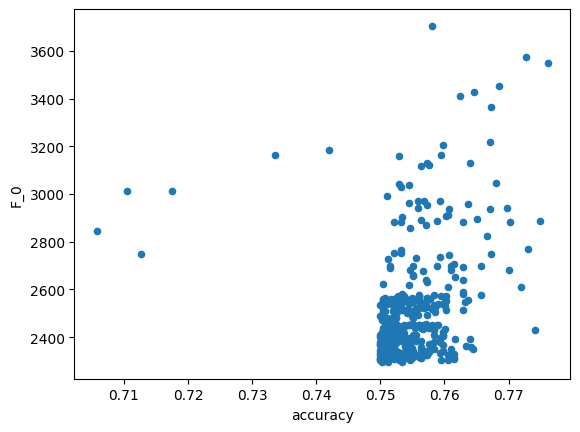

In [9]:
df_prep.plot(kind='scatter', x='accuracy', y='F_0')
# df8x8.plot(kind='scatter', x='accuracy', y='F_0')
# df8x8alt.plot(kind='scatter', x='accuracy', y='F_0')
# df16x16.plot(kind='scatter', x='accuracy', y='F_0')
# df1x16.plot(kind='scatter', x='accuracy', y='F_0')

# print(f"8x8 max: {df8x8['F_0'].max()}")
# print(f"16x16 max: {df16x16['F_0'].max()}")
# print(f"1x16 max: {df1x16['F_0'].max()}")

In [ ]:
for i, row in df_prep.iterrows():
    print(f"{i},0,nondom,{row['accuracy']}, {row['F_0']}")

In [ ]:
(i, row) = next(df_prep.iterrows())
for idx, p in enumerate(row['parameters']):
    print(f"({idx},{p})")

### Generate Bit plot

In [14]:
import numpy as np

df_constrained = df_prep[df_prep['F_0'] < 2600]
bit_mat = None

for i, row in df_constrained.iterrows():
    params = np.array(row['parameters'])
    if bit_mat is None:
        bit_mat = params
    else:
        bit_mat = np.vstack((bit_mat, params))

print(bit_mat.shape)

(301, 106)


In [15]:
bits = np.mean(bit_mat, axis=0)

<BarContainer object of 53 artists>

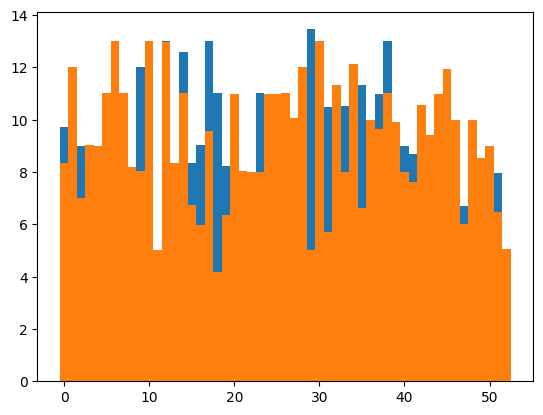

In [18]:
import matplotlib.pyplot as plt

input_bits = bits[0::2]
weight_bits = bits[1::2]

xi = list(range(input_bits.shape[0]))
xw = list(range(weight_bits.shape[0]))
plt.bar(xi, input_bits, width=1)
plt.bar(xw, weight_bits, width=1)

In [23]:
print("Inputs:", np.mean(input_bits))
print("Weights:", np.mean(weight_bits))

Inputs: 8.226791199147495
Weights: 9.16598758854134



Export for TikZ plot

In [26]:
for i, b in enumerate(input_bits):
    print(f"({i}, {b:.4f})")
print("")
for i, w in enumerate(weight_bits):
    print(f"({i}, {-w:.4f})")

(0, 9.7076)
(1, 11.0266)
(2, 8.9967)
(3, 7.9668)
(4, 7.0000)
(5, 7.4817)
(6, 5.5880)
(7, 7.7143)
(8, 6.8439)
(9, 12.0000)
(10, 4.0233)
(11, 5.0033)
(12, 13.0000)
(13, 4.9934)
(14, 12.5847)
(15, 8.3289)
(16, 9.0166)
(17, 13.0000)
(18, 11.0033)
(19, 8.2392)
(20, 7.0000)
(21, 6.5947)
(22, 5.2093)
(23, 11.0332)
(24, 5.9103)
(25, 4.0000)
(26, 5.4186)
(27, 8.9934)
(28, 11.0100)
(29, 13.4551)
(30, 7.5515)
(31, 10.4983)
(32, 5.0066)
(33, 10.5216)
(34, 9.9934)
(35, 11.3422)
(36, 6.9601)
(37, 11.0000)
(38, 13.0133)
(39, 9.9103)
(40, 9.0066)
(41, 8.6777)
(42, 6.0532)
(43, 7.9369)
(44, 10.6811)
(45, 7.0133)
(46, 4.4385)
(47, 6.7110)
(48, 5.3056)
(49, 4.9967)
(50, 4.3056)
(51, 7.9767)
(52, 4.9767)

(0, -8.3621)
(1, -11.9967)
(2, -7.0199)
(3, -9.0233)
(4, -8.9967)
(5, -11.0066)
(6, -13.0199)
(7, -11.0066)
(8, -8.2093)
(9, -8.0365)
(10, -12.9934)
(11, -5.0100)
(12, -12.9568)
(13, -8.3389)
(14, -11.0033)
(15, -6.7309)
(16, -5.9900)
(17, -9.5847)
(18, -4.1661)
(19, -6.3522)
(20, -10.9767)
(21, -8.0233)

## Compute the memory requirements

In [27]:
# resnet
from torchvision import models
from torchinfo import summary

resnet = models.resnet50()
summ = summary(resnet, (1, 3, 224, 224))



In [39]:
for layer in summ.summary_list:
    if layer.class_name == 'Conv2d' or layer.class_name == 'Linear':
        print(layer.input_size)
print("Layers: ", len(summ.summary_list))

[1, 3, 224, 224]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 128, 56, 56]
[1, 128, 28, 28]
[1, 256, 56, 56]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 256, 28, 28]
[1, 256, 14, 14]
[1, 512, 28, 28]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 512, 14, 14]
[1, 512, 7, 7]
[1, 1024, 14, 14]
[1, 2048, 7, 7]
[1, 512, 7, 7]
[1, 512, 7, 7]
[1, 2048, 7, 7]
[1, 512, 7, 7]
[1, 512, 7, 7]
[1, 2048]
Layers:  183


In [34]:
summ

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 